In [1]:
import time
import re
import datetime as pydt
import pandas as pd
%matplotlib inline

In [2]:
def parse_reset_time(line):
    line = line.strip()
    line = line.split("RESET:TIME: ", 1)[1]
    #The method split() returns a list of all the words in the string"line" 
    # -using 1st arg as the separator, and 2nd arg to limit the number of splits
    
    st = time.strptime(line, "%Y-%m-%d-%H-%M-%S") #returns <type 'time.struct_time'>
    #The method strptime() parses a string representing a time according to a format.
    
    return time.mktime(st) #returns <type 'float'> (unix time)
    #The method mktime() is the inverse function of localtime(). 
    # -Its argument is the struct_time or full 9-tuple and it returns a floating point number, for compatibility with time().

In [3]:
def parse_time(s, fmt):
    """Parses a human readable duration string into milliseconds.
    Takes a human readable duration string like '1d2h3m4s5ms' and returns
    the equivalent in milliseconds.
    Args:
    -s: Duration string
    -fmt: A re object to parse the string
    Returns:
    -A number indicating the duration in milliseconds.
    """
    if s == "0": return 0.0

    p = re.compile(fmt)
    match = p.search(s)
    try:
        d = match.groupdict()
    except IndexError:
        return -1.0

    ret = 0.0
    if d["day"]: ret += float(d["day"])*60*60*24
    if d["hrs"]: ret += float(d["hrs"])*60*60
    if d["min"]: ret += float(d["min"])*60
    if d["sec"]: ret += float(d["sec"])
    if d["ms"]: ret += float(d["ms"])/1000
    return ret

In [4]:
filename = 'batterystats.txt'

with open(filename) as file_object: 
    lines = file_object.readlines() #returns list of strings 
    
battery_list = [] 
ts_list = []
dt_list = []
prev_battery_level = -1

for i, line in enumerate(lines): 
    line.rstrip()
    if len(line.strip()) == 0: #empty line b/t battery data and "Per-PID Stats:"
        break
    
    if "RESET:TIME: " in line:
        data_start_time = parse_reset_time(line)
    elif (i!=0) and (not "Details:" in line) and (not "/proc/stat" in line):
    #ignore trivial rows: first row & "Details:" rows & "/proc/stat=17080" rows
        data = line.split()
        line_time = data[0] #duration like '1d2h3m4s5ms' (string)
        line_battery_level = int(data[2]) #battery percentage (int)
       
        fmt = (r"\+((?P<day>\d+)d)?((?P<hrs>\d+)h)?((?P<min>\d+)m)?"
           r"((?P<sec>\d+)s)?((?P<ms>\d+)ms)?$")
        time_delta_s = parse_time(line_time, fmt) #duration in seconds (float)
        ts = data_start_time + time_delta_s #unix time (float)       
        local_time = pydt.datetime.fromtimestamp(ts) #local time (datetime)
        
        battery_list.append(line_battery_level)
        ts_list.append(ts)
        dt_list.append(local_time)
        
        if line_battery_level != prev_battery_level:
            print str(local_time) + " " + str(line_battery_level) + " "+ str(type(line_battery_level))
        
        prev_battery_level = line_battery_level
        

2016-06-30 01:18:18 100 <type 'int'>
2016-06-30 02:38:19.676000 99 <type 'int'>
2016-06-30 04:58:18.803000 98 <type 'int'>
2016-06-30 07:48:18.841000 97 <type 'int'>
2016-06-30 10:28:19.889000 96 <type 'int'>
2016-06-30 13:18:18.997000 95 <type 'int'>
2016-06-30 15:58:19.003000 94 <type 'int'>
2016-06-30 18:28:19.078000 93 <type 'int'>
2016-06-30 20:48:19.124000 92 <type 'int'>
2016-06-30 23:28:19.205000 91 <type 'int'>
2016-07-01 02:08:19.221000 90 <type 'int'>
2016-07-01 04:28:19.279000 89 <type 'int'>
2016-07-01 07:18:19.326000 88 <type 'int'>
2016-07-01 10:04:41.964000 87 <type 'int'>
2016-07-01 10:05:05.307000 88 <type 'int'>
2016-07-01 10:05:43.140000 87 <type 'int'>


In [5]:
df = pd.DataFrame(data={'metadata_write_ts': ts_list, 'ts': ts_list, 'local_dt': dt_list, 'battery_level_pct': battery_list})
df.to_csv('batterystats_parsed.csv')
df

,battery_level_pct,local_dt,metadata_write_ts,ts
0,100,2016-06-30 01:18:18.000,1.467264e+09,1.467264e+09
1,100,2016-06-30 01:18:18.000,1.467264e+09,1.467264e+09
2,100,2016-06-30 01:18:18.000,1.467264e+09,1.467264e+09
3,100,2016-06-30 01:18:18.259,1.467264e+09,1.467264e+09
4,100,2016-06-30 01:18:22.539,1.467264e+09,1.467264e+09
5,100,2016-06-30 01:18:22.568,1.467264e+09,1.467264e+09
6,100,2016-06-30 01:18:22.569,1.467264e+09,1.467264e+09
7,100,2016-06-30 01:18:22.844,1.467264e+09,1.467264e+09
8,100,2016-06-30 01:18:22.849,1.467264e+09,1.467264e+09
9,100,2016-06-30 01:18:23.012,1.467264e+09,1.467264e+09


In [6]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2650 entries, 0 to 2649
Data columns (total 4 columns):
battery_level_pct    2650 non-null int64
local_dt             2650 non-null datetime64[ns]
metadata_write_ts    2650 non-null float64
ts                   2650 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 82.9 KB


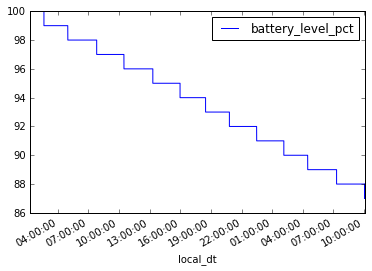

In [7]:
df.plot(x='local_dt', y='battery_level_pct')